In [1]:
import umap
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
IDs=[]
X=[]
with open("./iain_label_test.csv","r") as f:
    s=f.readline()
    while True:
        s=f.readline()
        if not s:
            break 
        ID = s.split(",")[0]
        x  = s[len(ID)+3:-3].split(",")
        X.append(np.array(x))
X = np.vstack(X)
print(X.shape)
        
        
    

(503, 9)


In [3]:
Xn = normalize( X, norm='l2', axis=0 )
nclass = 2

#
#  Umap is somewhat usable for easy case (1),
# but does not work so well for few labels (2)
#which_labels = 1
which_labels = 2

if which_labels==1: # easy case
    # alt. label everything 1/3 class 0, 1/3 class 1, 1/3 unlabeled(-1)
    target = np.array(np.random.randint(0,3,X.shape[0]))[:,None]
if which_labels==2: # very few labels, different class cardinalities
    target = np.full((X.shape[0],1), -1, dtype=np.int8)
    target[-10:-3] = 0
    target[-3:] = 1

print("target shape ",target.shape)
print("target[-20:]", target[-20:])

# try defaults - like tutorial
# Euclidean embedding
Euc_map = umap.UMAP(random_state=42,
                    metric='euclidean',
                    #target_weight = 0.9,
                    n_neighbors=9,
                    #target_n_neighbors=3,
                    #verbose=True
   ).fit( Xn ) #, y=target )
Cat_map = umap.UMAP(random_state=42,
                    metric='categorical',
                    n_neighbors=9 # horrible (and slow) int(X.shape[0]/2),
             ).fit( target )

#      print("UMAP ends SemiSupervised")


target shape  (503, 1)
target[-20:] [[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]]


/local/kruus/miru/umap-constraints/umap/umap_.py:1859: UserWarning: gradient function is not yet implemented for categorical distance metric; inverse_transform will be unavailable
  warn(


In [4]:
print(Euc_map.embedding_)
print(Cat_map.embedding_)

[[ 8.19755    6.1632214]
 [ 7.8178153  6.6385164]
 [10.165638   4.5602965]
 ...
 [ 9.995141   8.910422 ]
 [ 9.726896   8.493389 ]
 [ 8.0312805  5.622532 ]]
[[ 6.0149493   3.1888115 ]
 [ 1.8559664   0.24297409]
 [ 3.141823   -0.156921  ]
 ...
 [ 1.8636824   3.203845  ]
 [ 1.9072455   3.1536243 ]
 [ 1.9359933   3.230079  ]]


In [5]:
target

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],

[[9.995141  8.910422 ]
 [9.726896  8.493389 ]
 [8.0312805 5.622532 ]]


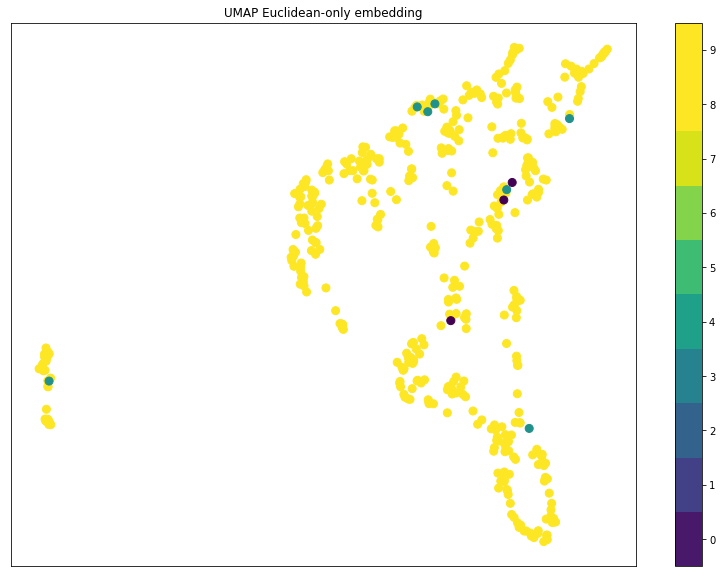

In [6]:
tcolor = -0.5 + 12*((nclass-(target+1))/(nclass+1))

print(Euc_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*Euc_map.embedding_.T, s=64.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Euclidean-only embedding');


Now with so few categorical labels, *everything* will essentially have distance 1.0
to everything else.  Also if class oridinalities differ widely, there might be
trouble in finding a decent knn setting.

The unfortunate consequence is that same-labels should cluster, most of the *Cat_map* connectivity is just "random noise".  I worry that this noise will *infect* the combined
graphs, later on!

[[1.8636824 3.203845 ]
 [1.9072455 3.1536243]
 [1.9359933 3.230079 ]]


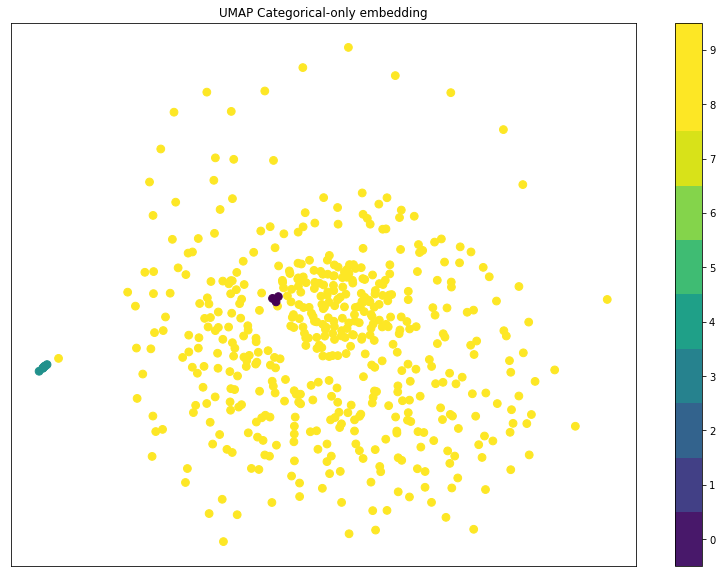

In [7]:
print(Cat_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*Cat_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Categorical-only embedding');


### Combining the two umap embeddings
This can be done in a variety of ways.

The default method is *intersection* of the two connectivity graphs.
This means edges that are present in BOTH graphs get used.
So if the Categorical labels are not within 9 knn of the Euclidean embedding,
they essentially do nothing.

You can see [umap examples of composing models](https://umap-learn.readthedocs.io/en/latest/composing_models.html) where the 'diamonds' dataset
is most similar -- there are continuous variables like price, that can be combined
with several ordinal classes for cut, grade, ...

Let's see this in action for this toy problem.

[[ 0.87294436  9.983436  ]
 [ 0.68895036 10.        ]
 [ 0.65880144  8.963791  ]]


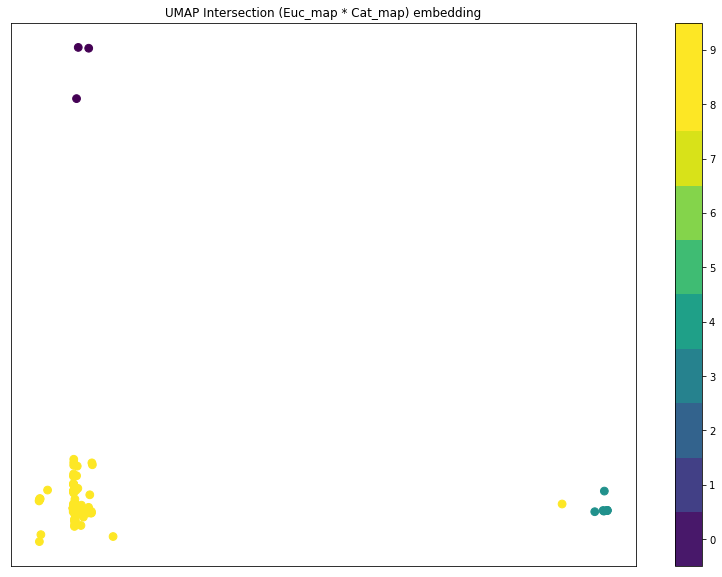

In [8]:
intersection_mapper = Euc_map * Cat_map  # *, +, - for intersection, union, difference
#
print(intersection_mapper.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*intersection_mapper.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Intersection (Euc_map * Cat_map) embedding');
#

OK, that wasn't as bad as I expected.  Maybe adjusting Euc knn can help?

So how about union?  Roughly, edges in either graph get used in the result.

[[ 2.0360239   9.520207  ]
 [ 0.8419887   9.906245  ]
 [ 0.84065366 10.        ]]


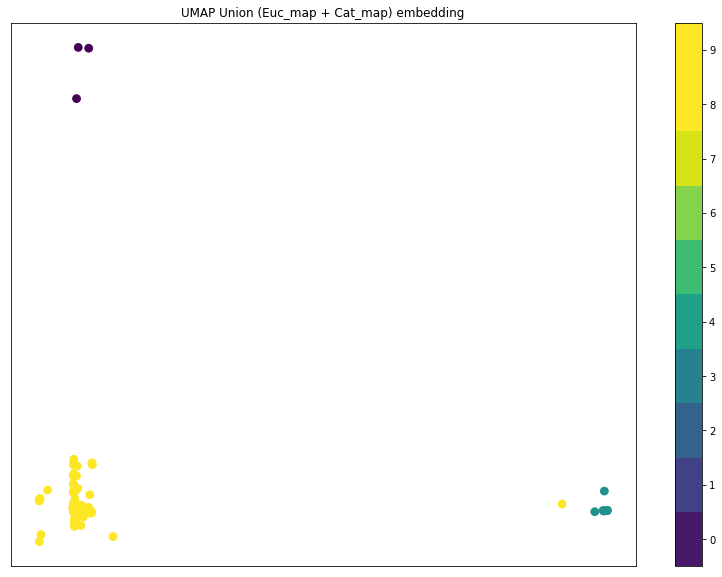

In [9]:
union_mapper = Euc_map + Cat_map  # *, +, - for intersection, union, difference
#
print(union_mapper.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*intersection_mapper.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Union (Euc_map + Cat_map) embedding');
#
if False:
    diff_mapper = Euc_map - Cat_map  # *, +, - for intersection, union, difference
    #
    print(diff_mapper.embedding_[-3:])
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*intersection_mapper.embedding_.T, s=10.0, c=target*100.0, cmap='prism', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    #cbar.set_ticklabels(classes)
    plt.title('UMAP Difference (Euc_map - Cat_map) embedding');
#

So not much difference.  Intersection does cluster, but really the weighting
between Euclidean and Categorical is not so great.

Looking into the '\*' intersection operator  (method *\_\_mul\_\_*) it's basically
runs *general_simplicial_set_intersection* (with default weight 0.5) and then
fixes up the resulting graph.   It's a bit complicated to do by hand.  So I
added a weight parameter to a new *mul\_helper* version of *\_\_mul\_\_*, that
takes an option *weight* parameter to pass into the general intersection.

[[ 2.0360239   9.520207  ]
 [ 0.8419887   9.906245  ]
 [ 0.84065366 10.        ]]


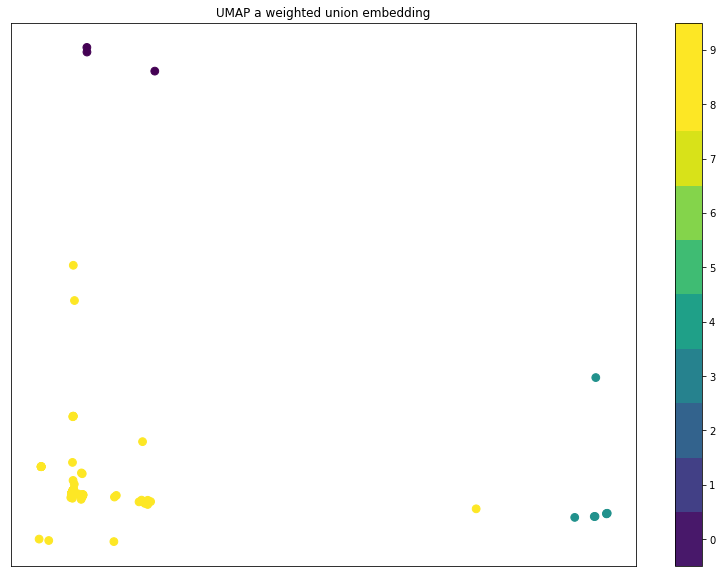

In [10]:
if which_labels==1:
    uw_map = Euc_map.__add__(Cat_map, weight=1)  # local modification of graph combiners to also accept a weight
if which_labels==2:
    uw_map = Euc_map.__add__(Cat_map, weight=0.999)  # local modification of graph combiners to also accept a weight
# There is no effect noticable from combining the weight.
# With so many unlabelled data, the categorical graph pushes almost everything unlabelled to "far".
#
print(uw_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*uw_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP a weighted union embedding');
#

intersect weight 0.43
[[0.98336244 0.        ]
 [0.73346984 0.0249288 ]
 [0.7073248  0.07689793]]


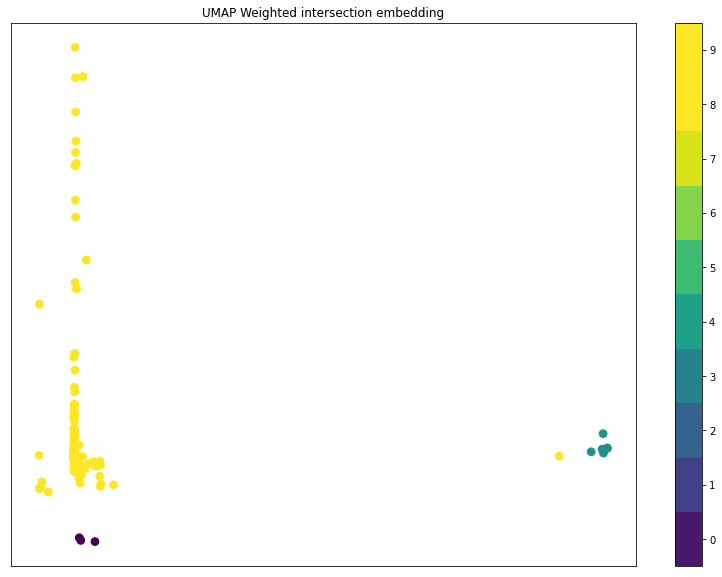

In [11]:
if which_labels==1:
    iw_map = Euc_map.__mul__(Cat_map, weight=0.42)  # local modification of graph combiners to also accept a weight
if which_labels==2:
    iw_map = Euc_map.__mul__(Cat_map, weight=0.43)  # local modification of graph combiners to also accept a weight
# There is no effect noticable from combining the weight.
# With so many unlabelled data, the categorical graph pushes almost everything unlabelled to "far".
#
print(iw_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*iw_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Weighted intersection embedding');
#

[[-1.9324774  2.958852 ]
 [-1.800312   3.0031796]
 [ 0.0705957  5.6970716]]


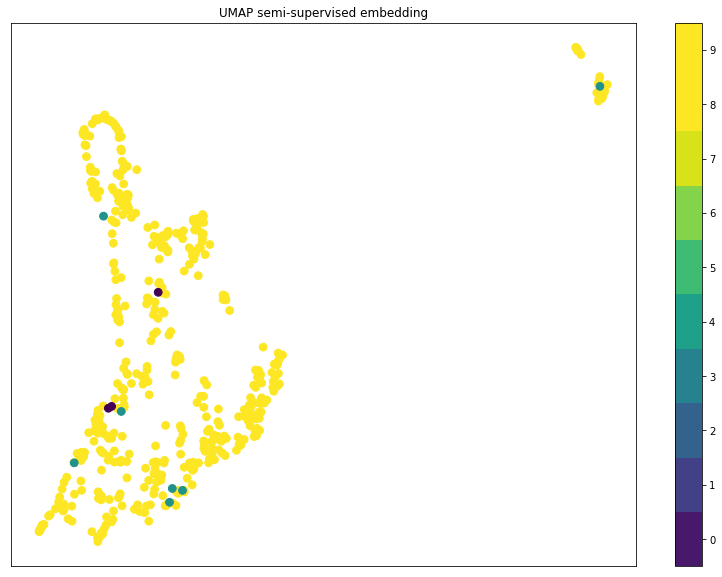

In [12]:
if which_labels==1:
    tw = 1.1
if which_labels==2:
    # there is NO GOOD VALUE for the umap built-in to get clusters
    tw = 0.99

u_map = umap.UMAP(random_state=42,
                    metric='euclidean',
                    n_neighbors=9,
                    target_metric='categorical',
                    target_weight = tw,
                    target_n_neighbors=9,
                    #verbose=True
   ).fit( Xn, y=target )
print(u_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*u_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP semi-supervised embedding');
#

So the UMAP result looks *the same*, and "washes out" too much of the Euclidean graph. There is almost
no effect from playing with n_neighbors, target_n_neighbors, or target_weight.

### OK, so now for something different.
A custom metric can be constructed as follows.

1. append a one-hot class vector to X dimensions
    - if no label, append a zero vector
    - if label, set value in that dim to LBL (default 1.0)
2. now euclidean metric can weight euclidean and categorical data *before* UMAP
   constructs its knn graph.
    - a *high LBL* value means the label data is effectively *more important*.


In [13]:
print("Xn.shape",Xn.shape)
print("nclasses",nclass)
xxshape = (Xn.shape[0], Xn.shape[1]+nclass)
print("xxshape",xxshape)
Xx = np.zeros( xxshape, dtype=np.float64)
print("Xx.shape",Xx.shape)
Xx[:,0:Xn.shape[1]] = Xn
print("target shape",target.shape)

def xxlabel():
    global LBL
    global Xx
    for i in range(target.shape[0]):
        #print(target[i,0])
        lbl = target[i,0]
        if lbl>=0: # i.e one of {0, ..., nclass-1}
            Xx[i, Xn.shape[1]+lbl] = LBL

LBL = 1.11111111111
xxlabel()
print("Xx[-4:]",Xx[-4:])

Xn.shape (503, 9)
nclasses 2
xxshape (503, 11)
Xx.shape (503, 11)
target shape (503, 1)
Xx[-4:] [[ 0.06397849 -0.04973055 -0.04532789  0.06375635 -0.05004528 -0.04351736
   0.06362884 -0.04823032 -0.04346878  1.11111111  0.        ]
 [ 0.03590461 -0.04039909 -0.06526878  0.03688418 -0.03673174 -0.05848837
   0.03743605 -0.03663286 -0.05665784  0.          1.11111111]
 [ 0.0398587  -0.05990358 -0.05975404  0.04144559  0.         -0.06034961
   0.04208047 -0.06458705 -0.06018497  0.          1.11111111]
 [ 0.0385889  -0.03706788 -0.02523662  0.03783949 -0.04618027 -0.02091528
   0.03740536 -0.04807149 -0.01942501  0.          1.11111111]]


*Xn* has normalized item vectors.

First we have extended dimensionality adding *nclass* zeros.
Then if we had label C, we set the C'th added zero to a big value *LBL*.

A big *LBL* puts same-class items *very far* from all other points, and
close (original euclidean distance) to all same-class points.

Distances between unlabeled items also retain their original euclidean distance.

- **Distances from a labeled to other-label will tend to be higher than distances to unlabelled.**
- In principle, it might be nicer to not add *additional labeled-class repulsions*
- But actually you might like labeled-clusters to feel some repulsion!

(I think)  Let's see how this works out:

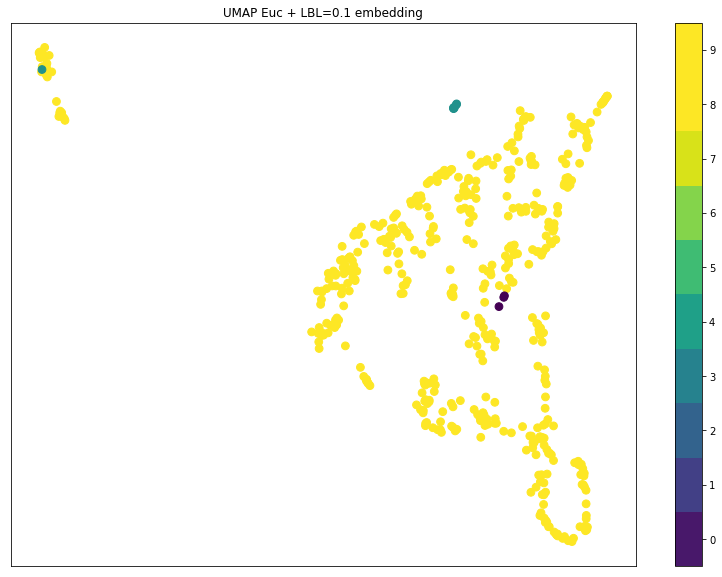

In [14]:
LBL = 0.1  # very tiny clustering one-hot dims -- not enough to force clusters
xxlabel()
# Euclidean embedding of Xx
xxmap = umap.UMAP(random_state=42,
                  metric='euclidean',
                  n_neighbors=9,
                 ).fit( Xx )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xxmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

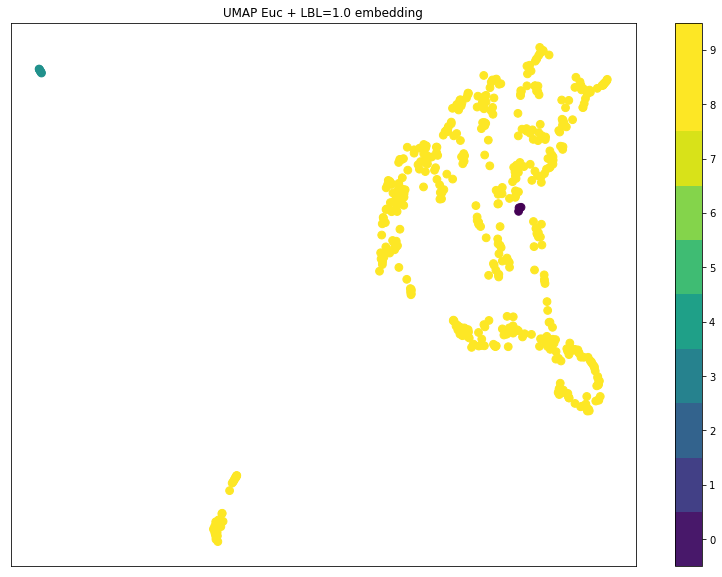

In [15]:
LBL = 1.0  # since Xn was normalized, even 1.0 is enough to cluster well
xxlabel()
xxmap = umap.UMAP(random_state=42,
                  metric='euclidean',
                  n_neighbors=9,
                 ).fit( Xx )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xxmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

#### metric='precomputed'
Here we provide the full distance matrix as input.  This allows us to
scale exactly what we want by exactly how much we want.

- Distances un-un, cl-un, cl-cl' (no change)
- Distances cl-cl --> multiply by scale < 1.0 (known-same-class move closer)

One flaw here is that we destroy having a metric!
i.e. we are quite likely to destroy triangle inequality!

In [16]:
#t1d = target[:,0]
#print("t1d",t1d[-20:])
#labeled = np.where( t1d>=0 )
labeled = np.where( target[:,0]>=0 )[0] # nb [0]
print("labeled:", labeled)
print(len(labeled))
print(labeled.size)

labeled: [493 494 495 496 497 498 499 500 501 502]
10
10


d 493 493 = 0.0 * 0.0001
d 493 494 = 0.17442696515990033 * 0.0001
d 493 495 = 0.09701274531725543 * 0.0001
d 493 496 = 0.02804247273980761 * 0.0001
d 493 497 = 0.039919805200000824 * 0.0001
d 493 498 = 0.029865856240860193 * 0.0001
d 493 499 = 0.09252971844006364 * 0.0001
d 494 493 = 0.1744269651599003 * 0.0001
d 494 494 = 0.0 * 0.0001
d 494 495 = 0.2232154354371961 * 0.0001
d 494 496 = 0.16388444215173004 * 0.0001
d 494 497 = 0.18191247827201157 * 0.0001
d 494 498 = 0.17545575739442676 * 0.0001
d 494 499 = 0.2048148993537419 * 0.0001
d 495 493 = 0.09701274531725544 * 0.0001
d 495 494 = 0.2232154354371961 * 0.0001
d 495 495 = 0.0 * 0.0001
d 495 496 = 0.10948526573953747 * 0.0001
d 495 497 = 0.06174966939666106 * 0.0001
d 495 498 = 0.09644743955342584 * 0.0001
d 495 499 = 0.03754187227259777 * 0.0001
d 496 493 = 0.02804247273980761 * 0.0001
d 496 494 = 0.16388444215173004 * 0.0001
d 496 495 = 0.10948526573953747 * 0.0001
d 496 496 = 0.0 * 0.0001
d 496 497 = 0.0525168839300958 * 0.0001
d

/local/kruus/miru/umap-constraints/umap/umap_.py:1837: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


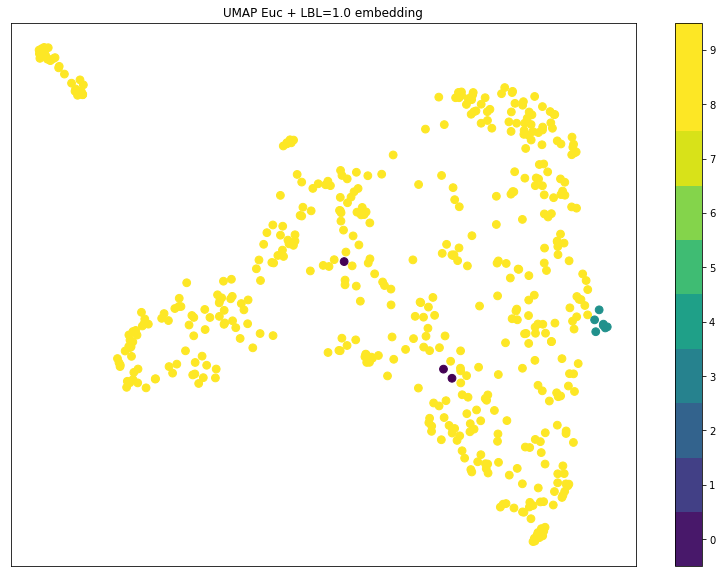

In [17]:
import sklearn
Xp = sklearn.metrics.pairwise_distances(Xn)
labeled = np.where( target[:,0]>=0 )[0]
def precomp(Xn, target, labeled, scale_same=0.1):
    Xp = sklearn.metrics.pairwise_distances(Xn)
    for i in range(labeled.size):
        li = labeled[i]
        ti = target[li,0]
        for j in range(labeled.size):
            lj = labeled[j]
            tj = target[lj,0]
            if ti == tj:
                print("d",li,lj,"=",Xp[li,lj],"*",scale_same)
                Xp[li,lj] *= scale_same
    return Xp
#
Xp = precomp(Xn, target, labeled, scale_same=1e-4)
print("Xp[0:4,0:4]",Xp[0:4,0:4])
print("Xp[-4:,-4:]",Xp[-4:,-4:])

# default set_op_mix_ratio is 1.0 ~ UNION fuzzy combination
xpmap = umap.UMAP(random_state=42,
                  metric='precomputed',
                  n_neighbors=30,
                 ).fit( Xp )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xpmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#